> Dataset:
https://www.kaggle.com/competitions/home-data-for-ml-course/data

> Train & test dataset: https://drive.google.com/file/d/1FYrVFjMT1BOfvlsVy_CdSm_Ivw9DkCFD/view?usp=sharing

> Validation dataset: https://drive.google.com/file/d/1-OG69sSMLiM3kfAAHzFA8qxl74X9u-mM/view?usp=sharing'

## Moi truong

In [ ]:
## Thư viện
import imageio
import joblib            as jlb
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import pydotplus         as pdp
import seaborn           as sbn

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

link = 'https://drive.google.com/file/d/1FYrVFjMT1BOfvlsVy_CdSm_Ivw9DkCFD/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + link.split('/')[-2]
df = pd.read_csv(path, encoding = 'unicode_escape')
# Xoá cột không cần thiết
df = df.drop(['Id'], axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


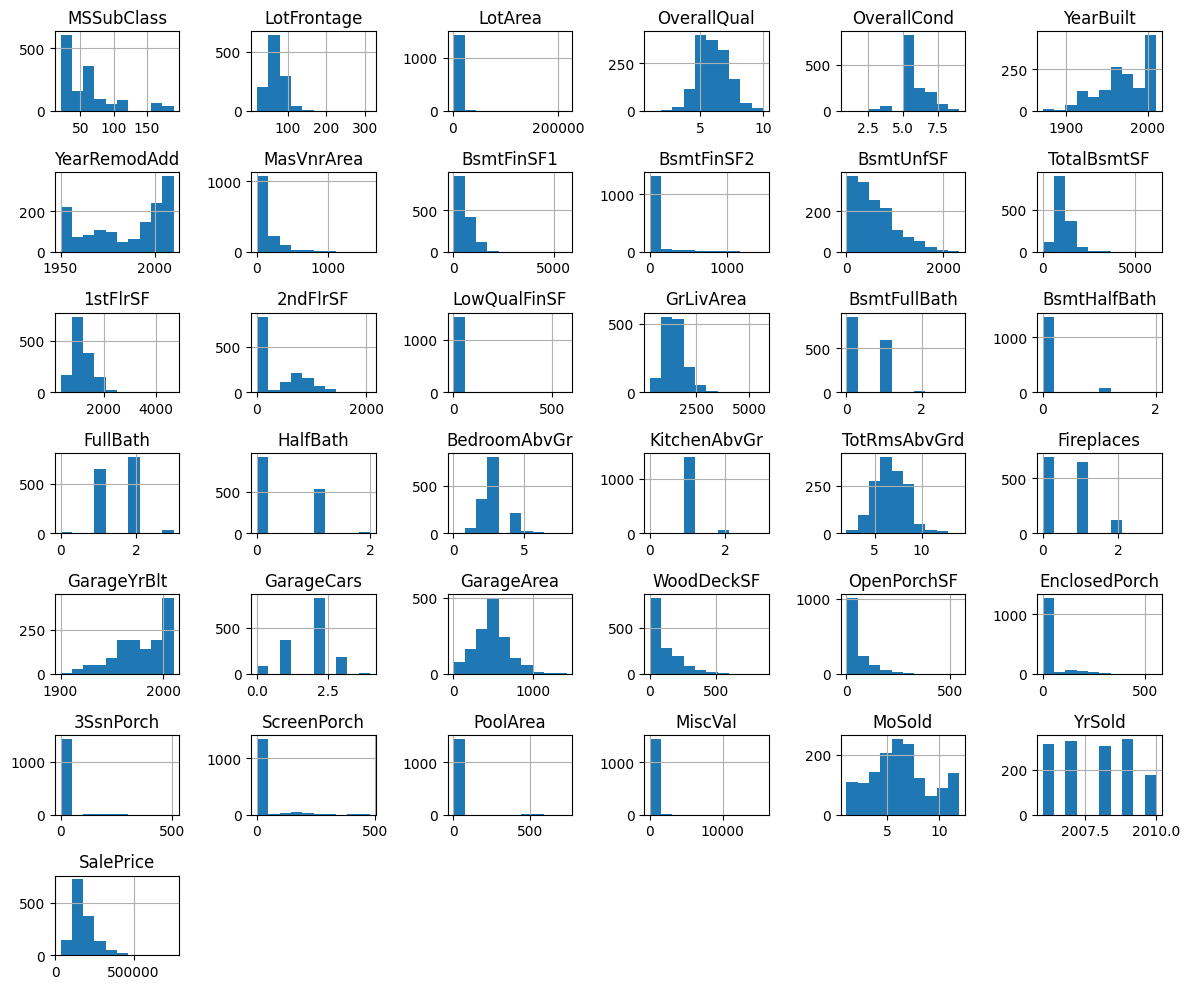

In [25]:
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# RANDOM FOREST TRONG BÀI TOÁN PHÂN LỚP


## Tiền xử lý dữ liệu

### DROP missing value COLS

In [ ]:
def miss_percent(df):
  missing_sr = df.isna().sum()
  missing_sr = missing_sr[missing_sr!=0]
  return missing_sr/df.shape[0]*100

# Xóa các cột có phần trăm missing values > 80%
cols_to_drop= miss_percent(df)[miss_percent(df)>80].index
df.drop(columns=cols_to_drop, axis = 1,inplace=True)
print(df.shape)

miss_percent(df)

(1460, 76)


LotFrontage     17.739726
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64

### DROP missing value ROWS

In [ ]:
## Xóa những dòng mà số giá trị khác Null KHÔNG ĐẠT NGƯỠNG TỐI THIỂU
print('Số dòng TRƯỚC khi xóa:', df.shape[0])
df = df.dropna(thresh = 9, inplace = False)
df.reset_index(drop=True, inplace=True)
print('Số dòng SAU khi xóa các dòng có số giá trị khác Null KHÔNG ĐẠT NGƯỠNG TỐI THIỂU:', df.shape[0])
# Xoá dư liệu trùng
df = df.drop_duplicates()
print('Số dòng SAU khi xóa dữ liệu trùng lặp:', df.shape[0])

Số dòng TRƯỚC khi xóa: 1460
Số dòng SAU khi xóa các dòng có số giá trị khác Null KHÔNG ĐẠT NGƯỠNG TỐI THIỂU: 1460
Số dòng SAU khi xóa dữ liệu trùng lặp: 1460


### FILL missing values

In [ ]:
# Tách biến features và target ra riêng để xử lý các features
X = df.drop('SaleCondition', axis=1)
y = df['SaleCondition']

# Xử lý giá trị bị thiếu bằng giá trị trung bình của cột
numeric_cols = X.select_dtypes(include=['number']).columns
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Xử lý giá trị bị thiếu bằng giá trị thường gặp nhất của mỗi cột
categorical_cols = X.select_dtypes(exclude=['number']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])
miss_percent(X)

Series([], dtype: float64)

### ENCODING

In [ ]:
# Dùng LabelEncoder để biến giá trị phân loại thành kiểu số
label_encoder = LabelEncoder()
X[categorical_cols] = X[categorical_cols].apply(lambda col: label_encoder.fit_transform(col.astype(str)))
print('Các cột dạng categorical còn lại trong X:')
X.select_dtypes(exclude=['number']).columns

Các cột dạng categorical còn lại trong X:


Index([], dtype='object')

### NORMALIZE

In [ ]:
# Chuẩn hóa đảm bảo rằng tất cả các features có trung bình là 0 và độ lệch chuẩn là 1.
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X[numeric_cols].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843


### OUTLIERS

In [ ]:
z_scores = np.abs((df.select_dtypes(include=['number']) - df.select_dtypes(include=['number']).mean()) / df.select_dtypes(include=['number']).std())

# Đặt ngưỡng cho Z-score
threshold = 3
filtered_entries = (z_scores > threshold).any(axis=1)
filtered_entries.sum()
X = X[~filtered_entries]
y = y[~filtered_entries]
print('Số dòng TRƯỚC khi xóa:', df.shape[0])
print('Số dòng SAU khi xóa:', X.shape[0])

Số dòng TRƯỚC khi xóa: 1460
Số dòng SAU khi xóa: 1017


### DECOMPOSITION PCA

In [ ]:
# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=0.9)  # Giữ lại 90% phương sai
X_pca = pca.fit_transform(X)
y = label_encoder.fit_transform(y)

preprocessed_data = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, X_pca.shape[1] + 1)])
preprocessed_data['SaleCondition'] = y

X = preprocessed_data.drop('SaleCondition', axis=1)
y = preprocessed_data['SaleCondition']
preprocessed_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,SaleCondition
0,7.035618,-3.239511,-3.099135,0.033899,-2.168411,0.156596,-1.360277,0.227379,-0.407327,1.985808,...,-0.174545,-0.086894,1.267975,0.005505,-0.453929,-0.442664,0.931218,0.993239,-0.303199,4
1,6.975801,-3.383676,-3.889207,-0.201636,-1.769487,-0.908469,-0.688734,-0.221227,-0.184625,0.750304,...,0.039363,-0.524699,0.538733,-0.154812,-0.340140,-0.347781,-0.914029,-0.641548,0.458918,4
2,-3.105372,-4.889386,-4.486935,-0.116641,-1.324504,-2.731219,-0.107450,0.521886,0.330851,-0.586656,...,-0.013372,-0.529687,0.209140,-0.583194,0.772115,0.594572,-0.812956,-1.225517,-0.908820,4
3,-8.954018,-5.343739,-1.491586,-3.083902,0.801284,1.188033,-1.364366,1.076248,-0.058959,-0.781852,...,-0.358687,-0.040520,0.580233,-0.398593,1.056567,-0.162907,0.896445,-0.500781,0.147290,4
4,-7.334387,5.405637,2.743959,0.502050,0.805569,1.143930,-0.393555,2.669700,-0.793985,1.104989,...,0.255596,0.585608,0.763893,1.418515,-0.583514,-1.754623,0.682395,0.220048,-1.195017,4


#### hàm xử lý dữ liệu đầu vào mô hình để thực hiện dự đoán

In [ ]:
def preprocessing_data(df, target):
  cols_to_drop= miss_percent(df)[miss_percent(df)>80].index
  df.drop(columns=cols_to_drop, axis = 1,inplace=True)
  df_vali[target] = df_vali[target].apply(lambda x: x.upper()[:3])

  df = df.dropna(thresh = 9, inplace = False)
  df.reset_index(drop=True, inplace=True)
  df = df.drop_duplicates()
  Xt = df.drop(target, axis=1)
  yt = df[target]

  numeric_cols = Xt.select_dtypes(include=['number']).columns
  numeric_imputer = SimpleImputer(strategy='mean')
  Xt[numeric_cols] = numeric_imputer.fit_transform(Xt[numeric_cols])

  categorical_cols = Xt.select_dtypes(exclude=['number']).columns
  categorical_imputer = SimpleImputer(strategy='most_frequent')
  Xt[categorical_cols] = categorical_imputer.fit_transform(Xt[categorical_cols])
  label_encoder = LabelEncoder()
  Xt[categorical_cols] = Xt[categorical_cols].apply(lambda col: label_encoder.fit_transform(col.astype(str)))

  scaler = StandardScaler()
  Xt[numeric_cols] = scaler.fit_transform(Xt[numeric_cols])

  pca = PCA(n_components=X.shape[1])
  X_pca = pca.fit_transform(Xt)
  yt = label_encoder.fit_transform(yt)

  result = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, X_pca.shape[1] + 1)])
  result[target] = yt
  return result

### Validation dataset

In [ ]:
link1 = 'https://drive.google.com/file/d/1-OG69sSMLiM3kfAAHzFA8qxl74X9u-mM/view?usp=sharing'
path1 = 'https://drive.google.com/uc?export=download&id=' + link1.split('/')[-2]
df_vali = pd.read_csv(path1, encoding = 'unicode_escape')
# # Xoá cột không cần thiết
df_vali = df_vali.drop(['Id'], axis=1)
df_vali.shape

(1459, 79)

In [ ]:
preprocessed_data_valid = preprocessing_data(df_vali, 'SaleCondition')
X_valid = preprocessed_data_valid.drop(['SaleCondition'], axis=1)
y_valid = preprocessed_data_valid['SaleCondition']
preprocessed_data_valid.shape

(1459, 23)

## Xay dung mo hinh

### Chia tập huấn luyện và tập kiểm tra

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Chon N_ESIMATORS

In [ ]:
# Mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Danh sách các giá trị n_estimators bạn muốn thử
param_grid = {'n_estimators': [50, 100 , 150, 200]}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

# Tiến hành tìm kiếm trên lưới
grid_search.fit(X_train, y_train)

# In ra giá trị tốt nhất và thông số tương ứng
best_n_estimators = grid_search.best_params_['n_estimators']
print("Best n_estimators:", best_n_estimators)
print("Best Accuracy:", grid_search.best_score_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best n_estimators: 200
Best Accuracy: 0.8782700901310309
Test Accuracy: 0.9215686274509803


### Khởi tạo mô hình, fit mô hình

In [ ]:
rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

### Kết quả dự đoán

In [ ]:
X_valid.shape

(1459, 22)

In [ ]:
# Dự đoán và đánh giá trên tập huấn luyện
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Dự đoán và đánh giá trên tập kiểm thử
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Dự đoán và đánh giá trên tập validation
y_valid_pred = rf_model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

evaluation_results = pd.DataFrame({
    'Accuracy': [train_accuracy, test_accuracy, valid_accuracy]
}, index=['Train', 'Test', 'Validation'])
print(evaluation_results)

            Accuracy
Train       1.000000
Test        0.921569
Validation  0.800548


In [ ]:
cross_val_score(rf_model, X_train, y_train, cv = 10)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


array([0.87804878, 0.85365854, 0.86585366, 0.87654321, 0.86419753,
       0.87654321, 0.87654321, 0.87654321, 0.88888889, 0.92592593])

In [ ]:
y_pred = rf_model.predict(X_test)
labels = ['ABN', 'FAM', 'NOR', 'PAR']
df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=labels, columns=labels)
print(df_conf_matrix)

     ABN  FAM  NOR  PAR
ABN    0    0    8    0
FAM    0    0    1    0
NOR    2    0  175    0
PAR    0    0    5   13


In [ ]:
y_pred = rf_model.predict(X_valid)
labels = ['ABN', 'ADJ', 'ALL', 'FAM', 'NOR', 'PAR']
df_conf_matrix = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=labels, columns=labels)
print(df_conf_matrix)

     ABN  ADJ  ALL  FAM   NOR  PAR
ABN    0    0    0    0    83    6
ADJ    0    0    0    0     8    0
ALL    0    0    0    0    11    1
FAM    0    0    0    0    24    2
NOR    1    0    0    0  1160   43
PAR    1    0    0    0   111    8


## Biểu diễn mô hình 2D

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


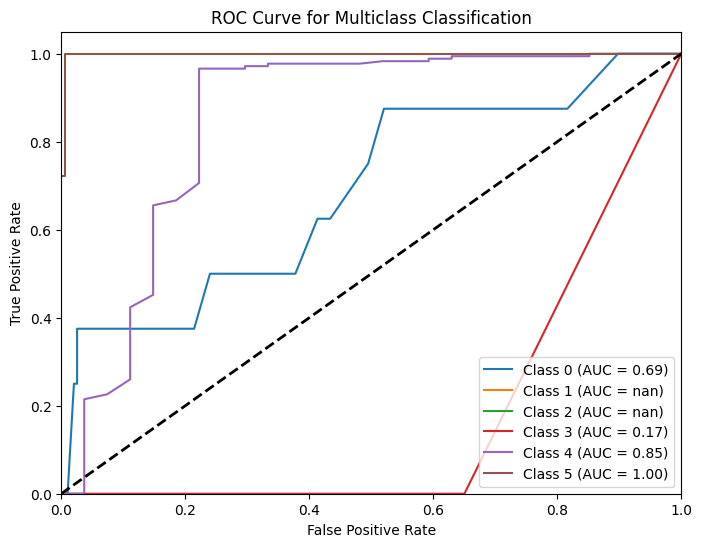

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# chia SaleCondition thành category
y_train_bin = label_binarize(y_train, classes=[i for i in range(0, y_train.nunique())])
y_test_bin = label_binarize(y_test, classes=[i for i in range(0,y_train.nunique())])

# Khởi tạo mô hình Random Forest
# rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
classifier = OneVsRestClassifier(rf_model)
classifier.fit(X_train, y_train_bin)

# Dự đoán xác suất của lớp dương (positive class)
y_pred_proba = classifier.predict_proba(X_test)

# Tính toán FPR cho đường cong ROC của mỗi lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(len(classifier.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Vẽ biểu đồ ROC
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

# Đánh giá mô hình

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
k = int(pow(X_train.shape[0], 1/2) / 2)
knn = KNeighborsClassifier(n_neighbors=k)

# Khởi tạo đối tượng KFold với số fold = 10
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Tạo danh sách để lưu trữ các kết quả đánh giá
##randomforest
rf_accuracy_scores = []
rf_precision_scores = []
rf_recall_scores = []
rf_f1_scores = []
##knn
knn_accuracy_scores = []
knn_precision_scores = []
knn_recall_scores = []
knn_f1_scores = []

# Lặp qua từng fold và thực hiện huấn luyện và đánh giá
for train_index, test_index in kfold.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Huấn luyện mô hình trên tập huấn luyện
    rf_model.fit(X_train_fold, y_train_fold)
    knn.fit(X_train_fold, y_train_fold)

    # Dự đoán nhãn cho tập kiểm tra
    y_pred_rf = rf_model.predict(X_test_fold)
    y_pred_knn = knn.predict(X_test_fold)

    # Tính toán các độ đo
    ##randomforest
    rf_accuracy = accuracy_score(y_test_fold, y_pred_rf)
    rf_precision = precision_score(y_test_fold, y_pred_rf, average='macro', zero_division=1)
    rf_recall = recall_score(y_test_fold, y_pred_rf, average='macro')
    rf_f1 = f1_score(y_test_fold, y_pred_rf, average='macro')
    ##knn
    knn_accuracy = accuracy_score(y_test_fold, y_pred_knn)
    knn_precision = precision_score(y_test_fold, y_pred_knn, average='macro', zero_division=1)
    knn_recall = recall_score(y_test_fold, y_pred_knn, average='macro')
    knn_f1 = f1_score(y_test_fold, y_pred_knn, average='macro')

    # Lưu kết quả vào danh sách
    ##randomforest
    rf_accuracy_scores.append(rf_accuracy)
    rf_precision_scores.append(rf_precision)
    rf_recall_scores.append(rf_recall)
    rf_f1_scores.append(rf_f1)
    ##knn
    knn_accuracy_scores.append(knn_accuracy)
    knn_precision_scores.append(knn_precision)
    knn_recall_scores.append(knn_recall)
    knn_f1_scores.append(knn_f1)

# Tính trung bình các độ đo trên các fold
##randomforest
rf_mean_accuracy = sum(rf_accuracy_scores) / len(rf_accuracy_scores)
rf_mean_precision = sum(rf_precision_scores) / len(rf_precision_scores)
rf_mean_recall = sum(rf_recall_scores) / len(rf_recall_scores)
rf_mean_f1 = sum(rf_f1_scores) / len(rf_f1_scores)
##knn
knn_mean_accuracy = sum(knn_accuracy_scores) / len(knn_accuracy_scores)
knn_mean_precision = sum(knn_precision_scores) / len(knn_precision_scores)
knn_mean_recall = sum(knn_recall_scores) / len(knn_recall_scores)
knn_mean_f1 = sum(knn_f1_scores) / len(knn_f1_scores)

# In kết quả
comparison_results = pd.DataFrame({
    'Accuracy Mean': [rf_mean_accuracy, knn_mean_accuracy],
    'Precision Mean': [rf_mean_precision, knn_mean_precision],
    'Recall Mean': [rf_mean_recall, knn_mean_recall],
    'F1-score Mean': [rf_mean_f1, knn_mean_f1]
}, index=['RandomForest', 'KNN'])
print(comparison_results)

              Accuracy Mean  Precision Mean  Recall Mean  F1-score Mean
RandomForest       0.887896        0.866794     0.432452       0.454617
KNN                0.839720        0.858820     0.286206       0.291873


# **RANDOM FOREST TRONG BÀI TOÁN HỒI QUY**

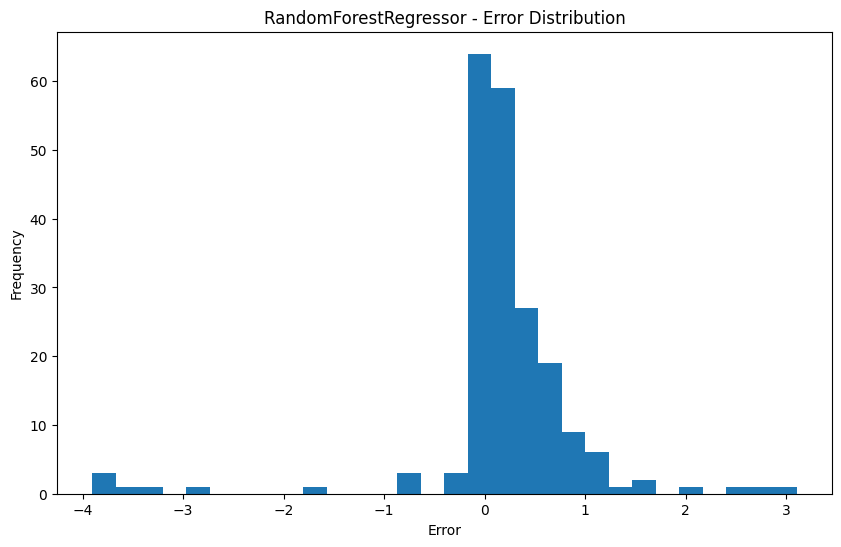

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model    import LinearRegression

# Khởi tạo và huấn luyện mô hình
rf_regressor = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
rf_regressor.fit(X_train, y_train)

# Dự đoán giá trị trên tập kiểm tra
y_pred = rf_regressor.predict(X_test)
# Tính toán sai số giữa giá trị dự đoán và giá trị thực tế trên tập kiểm tra
errors = y_test - y_pred

# Biểu diễn phân bố sai số trên đồ thị
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('RandomForestRegressor - Error Distribution')
plt.show()

# Đánh giá mô hình

In [ ]:
# Mô hình LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
# Sử dụng k-fold cross-validation và đánh giá mô hình
k = 5  # Số lượng fold
rf_scores = cross_val_score(rf_regressor, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
lr_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')

# Chuyển đổi điểm số từ âm thành dương
rf_mae_scores = -rf_scores
ln_mae_scores = -lr_scores

# Tính toán các chỉ số đánh giá trung bình
rf_mae_mean = rf_mae_scores.mean()
rf_mse_mean = mean_squared_error(y_train, rf_regressor.predict(X_train))
rf_rmse_mean = np.sqrt(rf_mse_mean)
rf_r2_mean = r2_score(y_train, rf_regressor.predict(X_train))

lr_mae_mean = ln_mae_scores.mean()
lr_mse_mean = mean_squared_error(y_train, model.predict(X_train))
lr_rmse_mean = np.sqrt(lr_mse_mean)
lr_r2_mean = r2_score(y_train, model.predict(X_train))

comparison_results = pd.DataFrame({
    'Mean Absolute Error (MAE)': [rf_mae_mean, lr_mae_mean],
    'Mean Squared Error (MSE)': [rf_mse_mean, lr_mse_mean],
    'Root Mean Squared Error (RMSE)': [rf_rmse_mean, lr_rmse_mean],
    'R^2 Score': [rf_r2_mean, lr_r2_mean]
}, index=['RandomForest', 'LinearRegression'])
print(comparison_results)

                  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
RandomForest                       0.544750                  0.145175   
LinearRegression                   0.632294                  1.063465   

                  Root Mean Squared Error (RMSE)  R^2 Score  
RandomForest                            0.381018   0.881858  
LinearRegression                        1.031244   0.134562  


RandomForest có MAE, MSE, RMSE thấp hơn Linear Regression và R^2 Score cao hơn so với Linear Regression. Do đó RandomForest có hiệu suất tốt hơn so với Linear Regression trên tất cả các kết quả của bài toán.